In [18]:
import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm # tqdm is a package that lets you make progress bars to see how a loop is going

import os 

import pandas as pd # pandas is a popular library in industry for manipulating large data tables

from astropy.timeseries import LombScargle

# configure notebook for plotting
%matplotlib inline

mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme

# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(8.0,6.0)   
matplotlib.rcParams['font.size']=16              
matplotlib.rcParams['savefig.dpi']= 300             

import warnings
warnings.filterwarnings('ignore')

In [19]:
ddir_stars = '/Users/kobibrown/Desktop/Distance_Ladder_Project/' # this should be where you unzipped your data

In [20]:
ddir = ddir_stars + '/Variable_Star_Data/'

In [21]:
fname = 'BottomS047924.csv' # put your filename here

data = pd.read_csv(ddir+fname) # load in CSV data as a Pandas object
print(data.keys()) # see what's in it
time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables
dt = np.median(np.diff(time))
print('Nyquist Limit',0.5/dt,'cycles per hour') # can't get frequencies higher than the Nyquist limit

Index(['Time', 'NormalisedFlux'], dtype='object')
Nyquist Limit 0.5 cycles per hour


Text(0, 0.5, 'Relative Flux')

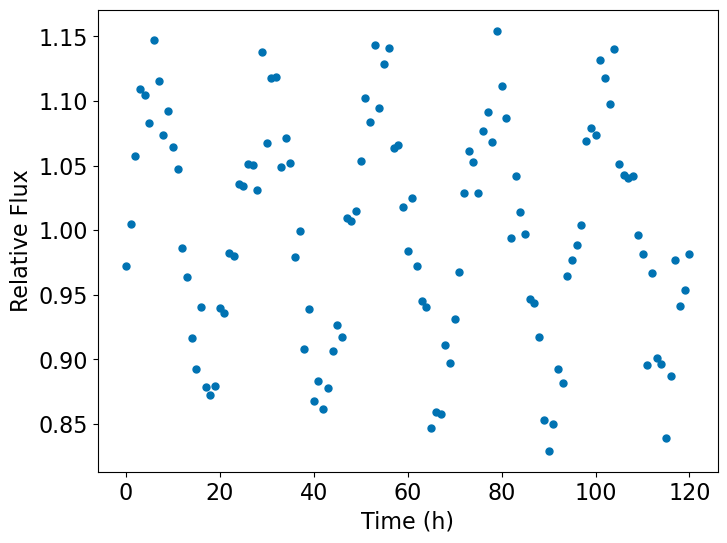

In [22]:
plt.plot(time,flux,'.',markersize=10)
plt.xlabel('Time (h)')
plt.ylabel('Relative Flux')

In [23]:
LS = LombScargle(time,flux) # initialize a Lomb-Scargle algorithm from Astropy
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
power = LS.power(freqs) # calculate LS power

In [24]:
print('Best period: %.2f h' % (1/freqs[np.argmax(power)]))

Best period: 24.12 h


Text(0, 0.5, 'LS Power')

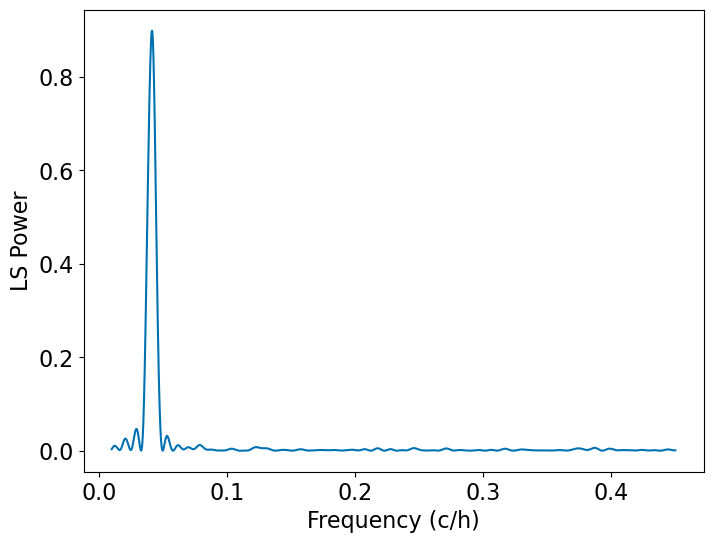

In [26]:
plt.plot(freqs,power)
plt.xlabel('Frequency (c/h)')
plt.ylabel('LS Power')

In [27]:
import glob # this package lets you search for filenames

fnames = glob.glob(ddir+'*.csv')
print(fnames[:10])

['/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/RightS102024.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/BackS159719.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/RightS090234.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/BottomS174827.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/RightS102030.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/BackS018745.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/RightS069685.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/BottomS175287.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/BackS147255.csv', '/Users/kobibrown/Desktop/Distance_Ladder_Project//Variable_Star_Data/RightS100141.csv']


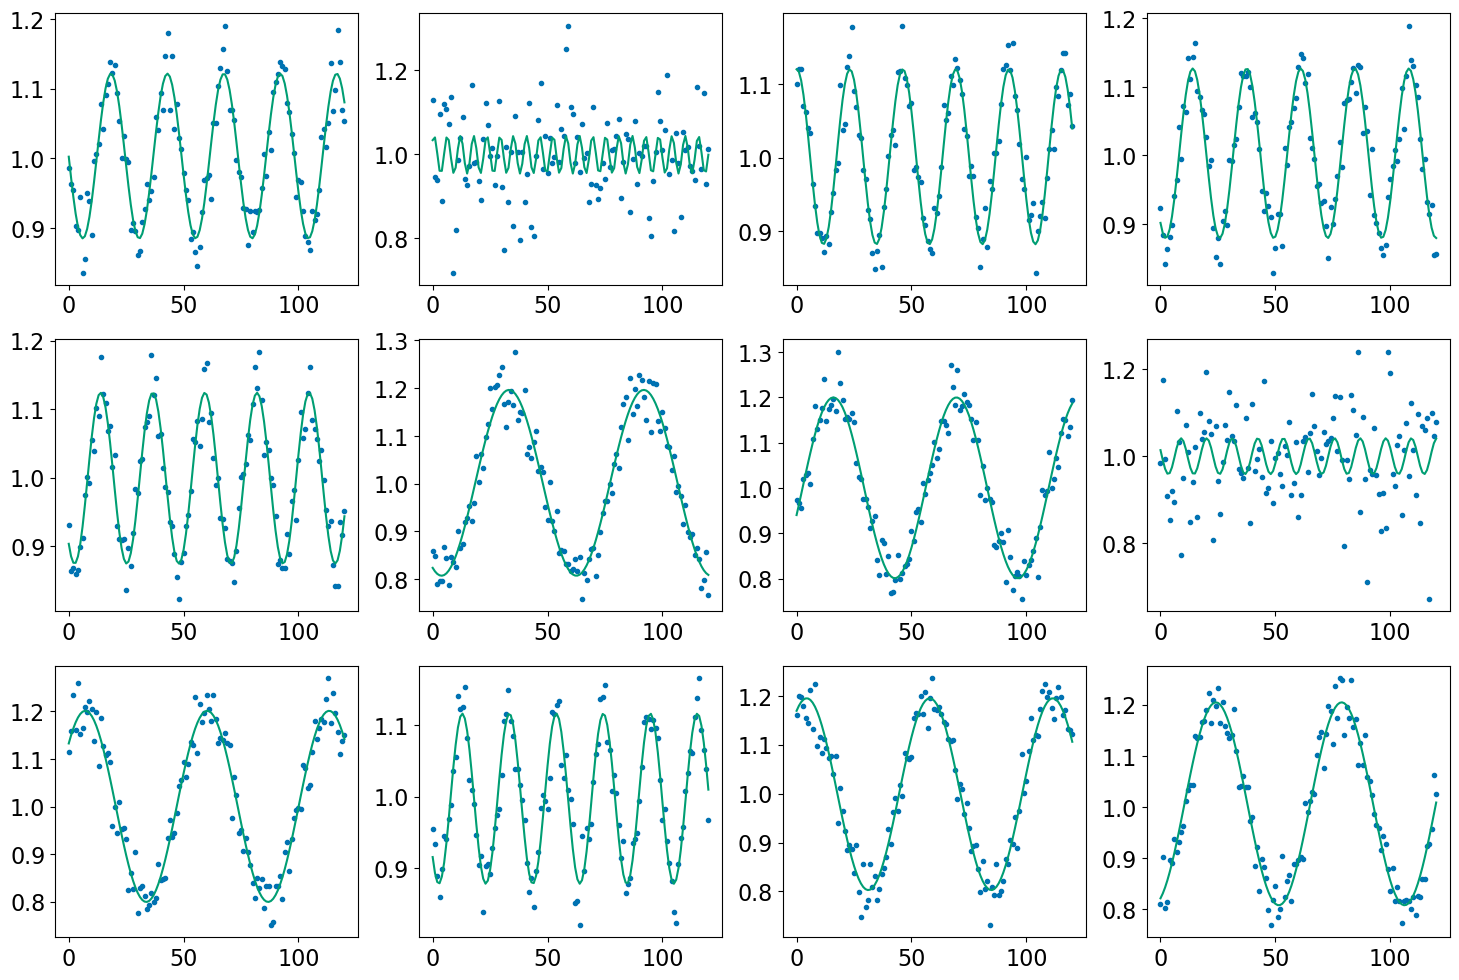

In [28]:
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 

fig, axes = plt.subplots(3,4,figsize=(18,12))
for fname, ax in zip(fnames[:12], axes.ravel()): # you can loop over two things
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    ax.plot(time,flux,'.')
    ax.plot(time,pred) # plot the model over the data
    
    periods.append(1/bestfreq) # add each period to the list
    
periods = np.array(periods) # turn it from a list to an array


In [29]:
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 
names = []

for fname in tqdm(fnames): # tqdm is a package that gives you a progress bar - neat! 
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    
    periods.append(1/bestfreq) # add each period to the list
    names.append(os.path.basename(fname).strip('.csv')) # os.path.basename gets rid of directories and gives you the filename; then we strip '.csv'
    
periods = np.array(periods) # turn it from a list to an array

100%|██████████████████████████████████████| 5788/5788 [00:20<00:00, 282.44it/s]


In [30]:
import glob # this package lets you search for filenames
import os

variables = pd.DataFrame({'Name':names,
              'Period':periods}) # you can turn a dictionary into a dataframe like this
variables.Name = variables.Name.astype('|S') # have to do this so that it knows the names are strings

all_star_files = glob.glob(ddir_stars+'*/Star_Data.csv')

all_stars = pd.concat([pd.read_csv(table) for table in all_star_files]) # we are concatenating a list of dataframes; 
#we generate this list with a "list comprehension", a loop you write inside a list bracket 

all_stars.Name = all_stars.Name.astype('|S') # have to do this so that it knows the names are strings
all_stars = all_stars[all_stars.Parallax > 0.01] # 10 mas parallax cut
print(len(all_stars),'stars above 10 mas parallax') # check how many stars there are total with good parallax

variables = pd.merge(all_stars,variables,on='Name') # merge these two arrays according to the keyword 'name'
print('Of which',len(variables),'variables') # cut down to a small list


1014 stars above 10 mas parallax


NotImplementedError: 

In [14]:
m0, m1, m2 = np.log10(all_stars['BlueF']), np.log10(all_stars['GreenF']), np.log10(all_stars['RedF']) 
colour = m2-m0
abs_mag = m1 + 2*np.log10(1./all_stars.Parallax) 

v0, v1, v2 = np.log10(variables['BlueF']), np.log10(variables['GreenF']), np.log10(variables['RedF']) 
variable_colour = v2-v0
abs_mag_v = v1 - 2*np.log10(1./variables.Parallax)

KeyError: 'BlueF'

Text(0.5, 0, 'Log Flux 2 - Log Flux 0')

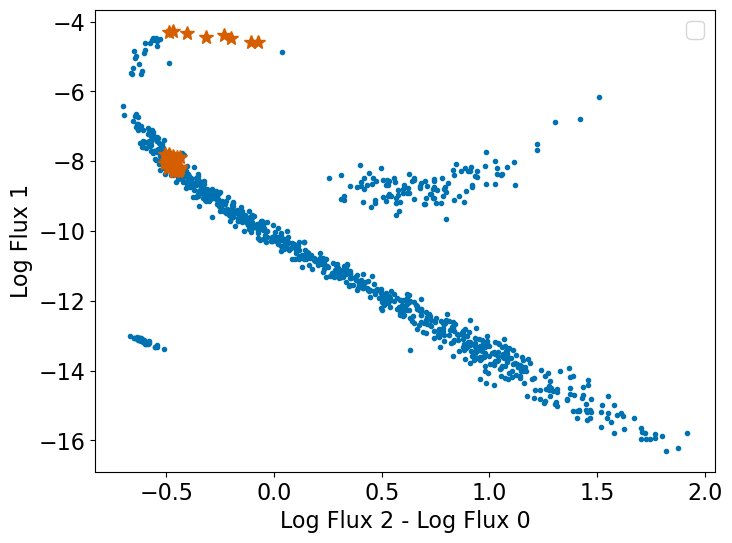

In [19]:
s = plt.plot(colour,abs_mag,'.C0')
h = plt.plot(variable_colour,abs_mag_v,'.C2',marker='*',markersize=10)

    
plt.legend([s, h],['Steady','Variable'])
plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

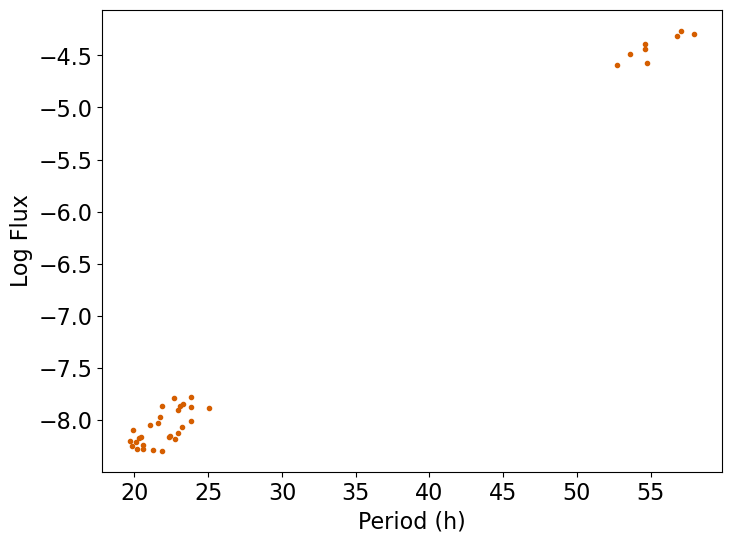

In [18]:
plt.plot(variables.Period,abs_mag_v,'.',color='C2')
plt.xlabel('Period (h)')
plt.ylabel('Log Flux');

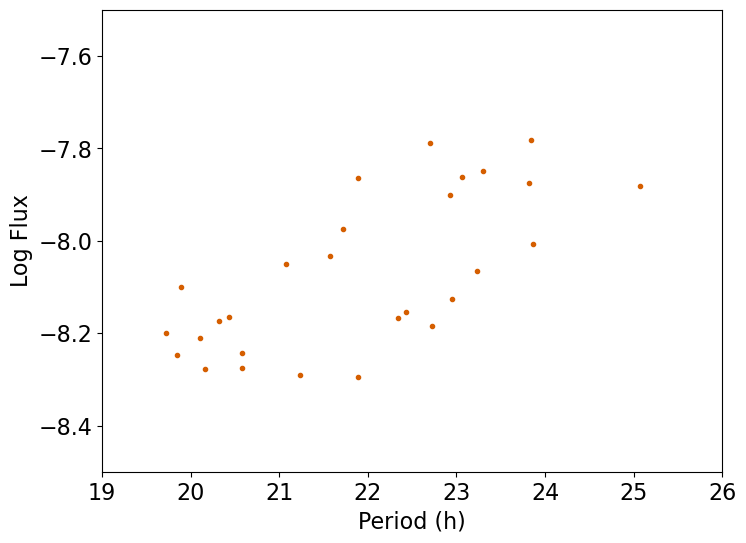

In [22]:
#Zooming in on the short-period variables

plt.plot(variables.Period,abs_mag_v,'.',color='C2')
plt.xlim(19,26)
plt.ylim(-8.5,-7.5)
plt.xlabel('Period (h)')
plt.ylabel('Log Flux');

In [31]:
datapath = '/Users/kobibrown/Desktop/Distance_Ladder_Project/' # this should be where you unzipped your data
variables.Period.to_csv(datapath + "/Period.csv", index=False, sep=',')